In [3]:
from collections import Counter

import dask
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import sklearn.datasets
import sklearn.decomposition
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

In [4]:
n_features = 2
n_classes = 3
n_samples = 150

data = sklearn.datasets.load_iris()
x = data['data']
y = data['target']

In [5]:
np.random.seed(1967)

data_order = np.random.permutation(np.arange(n_samples))
x, y = x[data_order], y[data_order]

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

In [6]:
# renormalize the features to be [-pi, pi]
x_min = np.min(x, axis=0)
x_max = np.max(x, axis=0)

x = 2 * np.pi * (x - x_min) / (x_max - x_min) - np.pi

In [7]:
split = 125

x_train = x[:split]
x_test = x[split:]
y_train = y[:split]
y_test = y[split:]

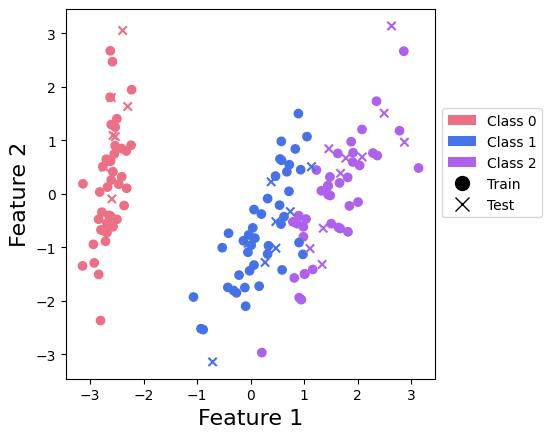

In [8]:
colours = ["#ec6f86", "#4573e7", "#ad61ed"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])

    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))


plot_points(x_train, y_train, x_test, y_test)
plt.show()

In [9]:
n_wires = 4

dev0 = qml.device("rigetti.qvm", device="4q-qvm")
dev1 = qml.device("qiskit.aer", wires=4)
devs = [dev0, dev1]

docker run -d -p 5555:5555 rigetti/quilc -R -p 5555
docker run -d -p 5000:5000 rigetti/qvm -S -p 5000

In [10]:
def circuit0(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[1, 0, i], wires=i)

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[3, 0])

    for i in range(n_wires):
        qml.Rot(*params[1, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))


def circuit1(params, x=None):
    for i in range(n_wires):
        qml.RX(x[i % n_features], wires=i)
        qml.Rot(*params[0, 0, i], wires=i)

    qml.CZ(wires=[0, 1])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[1, 3])

    for i in range(n_wires):
        qml.Rot(*params[0, 1, i], wires=i)
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2))

In [11]:
qnodes = [
    qml.QNode(circuit0, dev0),
    qml.QNode(circuit1, dev1),
]


In [31]:
def decision(softmax):
    return int(torch.argmax(softmax))


def predict_point(params, x_point=None, parallel=True):
    if parallel:
        results = tuple(dask.delayed(q)(params, x=x_point) for q in qnodes)
        results = dask.compute(*results, scheduler="threads")
        print(np.array(results))
        results = torch.tensor(np.array(results))
        
    else:
        results = tuple(q(params, x=x_point) for q in qnodes)
        results = torch.tensor(results)
    softmax = torch.nn.functional.softmax(results, dim=1)
    choice = torch.where(softmax == torch.max(softmax))[0][0]
    chosen_softmax = softmax[choice]
    return decision(chosen_softmax), decision(softmax[0]), decision(softmax[1]), int(choice)


In [32]:
def predict(params, x=None, parallel=True):
    predictions_ensemble = []
    predictions_0 = []
    predictions_1 = []
    choices = []

    for i, x_point in enumerate(x):
        if i % 10 == 0 and i > 0:
            print("Completed up to iteration {}".format(i))
        results = predict_point(params, x_point=x_point, parallel=parallel)
        predictions_ensemble.append(results[0])
        predictions_0.append(results[1])
        predictions_1.append(results[2])
        choices.append(results[3])

    return predictions_ensemble, predictions_0, predictions_1, choices

In [33]:
params = np.load("./data/ensemble_multi_gpu/params.npy")

In [34]:
print("Predicting on training dataset")
p_train, p_train_0, p_train_1, choices_train = predict(params, x=x_train)
print("Predicting on test dataset")
p_test, p_test_0, p_test_1, choices_test = predict(params, x=x_test)

Predicting on training dataset
[[ 0.914      -0.026      -0.634     ]
 [-0.42578125 -0.41601562 -0.3125    ]]
[[-0.988      -0.284       0.84      ]
 [-0.55859375  0.83398438 -0.38476562]]
[[-0.994      -0.312       0.762     ]
 [-0.671875    0.77539062 -0.5625    ]]
[[-0.276      -0.05       -0.174     ]
 [-0.79101562  0.97070312 -0.89257812]]
[[ 0.93       -0.26       -0.536     ]
 [ 0.87304688  0.89257812  0.76171875]]
[[ 0.932      -0.036      -0.714     ]
 [-0.41796875 -0.42773438 -0.2890625 ]]
[[-0.41       -0.07        0.23      ]
 [-0.87890625  0.9296875  -0.89453125]]
[[-0.966      -0.042       0.69      ]
 [-0.45117188  0.66601562 -0.27539062]]
[[-0.248       0.014       0.218     ]
 [-0.06445312 -0.3203125  -0.22460938]]
[[ 0.8        -0.11       -0.574     ]
 [-0.08984375 -0.07617188 -0.09570312]]
Completed up to iteration 10
[[-0.968      -0.34        0.852     ]
 [-0.640625    0.99414062 -0.37304688]]
[[-0.962      -0.332       0.894     ]
 [-0.63671875  0.95117188 -0.343

In [35]:
def accuracy(predictions, actuals):
    count = 0

    for i in range(len(predictions)):
        if predictions[i] == actuals[i]:
            count += 1

    accuracy = count / (len(predictions))
    return accuracy

In [36]:
print("Training accuracy (ensemble): {}".format(accuracy(p_train, y_train)))
print("Training accuracy (QPU0):  {}".format(accuracy(p_train_0, y_train)))
print("Training accuracy (QPU1):  {}".format(accuracy(p_train_1, y_train)))

Training accuracy (ensemble): 0.832
Training accuracy (QPU0):  0.648
Training accuracy (QPU1):  0.296


In [37]:
print("Test accuracy (ensemble): {}".format(accuracy(p_test, y_test)))
print("Test accuracy (QPU0):  {}".format(accuracy(p_test_0, y_test)))
print("Test accuracy (QPU1):  {}".format(accuracy(p_test_1, y_test)))

Test accuracy (ensemble): 0.72
Test accuracy (QPU0):  0.56
Test accuracy (QPU1):  0.24


In [38]:
# Combine choices_train and choices_test to simplify analysis
choices = np.append(choices_train, choices_test)
print("Choices: {}".format(choices))
print("Choices counts: {}".format(Counter(choices)))

Choices: [0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0
 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0
 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0
 0 0]
Choices counts: Counter({0: 111, 1: 39})


In [39]:
predictions = np.append(p_train, p_test)
choice_vs_prediction = np.array([(choices[i], predictions[i]) for i in range(n_samples)])

In [40]:
choices_vs_prediction_0 = choice_vs_prediction[choice_vs_prediction[:, 0] == 0]
choices_vs_prediction_1 = choice_vs_prediction[choice_vs_prediction[:, 0] == 1]
predictions_0 = choices_vs_prediction_0[:, 1]
predictions_1 = choices_vs_prediction_1[:, 1]


expl = "When QPU{} was chosen by the ensemble, it made the following distribution of " \
       "predictions:\n{}"
print(expl.format("0", Counter(predictions_0)))
print("\n" + expl.format("1", Counter(predictions_1)))
print("\nDistribution of classes in iris dataset: {}".format(Counter(y)))

When QPU0 was chosen by the ensemble, it made the following distribution of predictions:
Counter({2: 56, 0: 55})

When QPU1 was chosen by the ensemble, it made the following distribution of predictions:
Counter({1: 36, 0: 3})

Distribution of classes in iris dataset: Counter({0: 50, 2: 50, 1: 50})


In [41]:
colours_prediction = {"correct": "#83b5b9", "incorrect": "#f98d91"}
markers = ["o", "v", "d"]


def plot_points_prediction(x, y, p, title):
    c = {0: [], 1: [], 2: []}
    x_ = {0: [], 1: [], 2: []}

    for i in range(n_samples):
        x_[y[i]].append(x[i])
        if p[i] == y[i]:
            c[y[i]].append(colours_prediction["correct"])
        else:
            c[y[i]].append(colours_prediction["incorrect"])

    for i in range(n_classes):
        x_class = np.array(x_[i])
        plt.scatter(x_class[:, 0], x_class[:, 1], c=c[i], marker=markers[i])

    plt.xlabel("Feature 1", fontsize=16)
    plt.ylabel("Feature 2", fontsize=16)
    plt.title("Predictions from {} model".format(title))

    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(
            facecolor=colours_prediction["correct"],
            edgecolor=c_transparent, label="Correct"
        ),
        Patch(
            facecolor=colours_prediction["incorrect"],
            edgecolor=c_transparent, label="Incorrect"
        ),
        Line2D([0], [0], marker=markers[0], color=c_transparent, label="Class 0",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker=markers[1], color=c_transparent, label="Class 1",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker=markers[2], color=c_transparent, label="Class 2",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines, bbox_to_anchor=(1.0, 0.75))

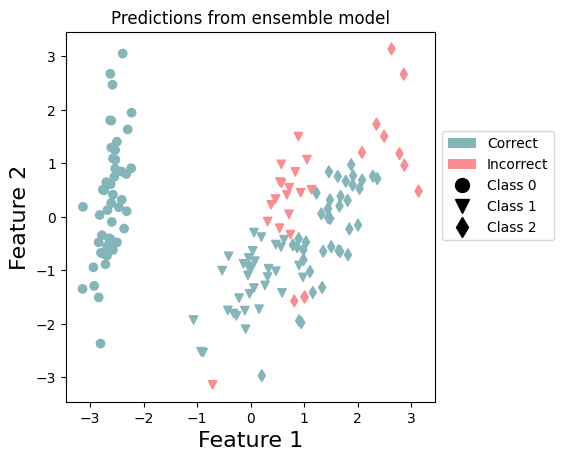

In [42]:
plot_points_prediction(x, y, predictions, "ensemble")  # ensemble
plt.show()

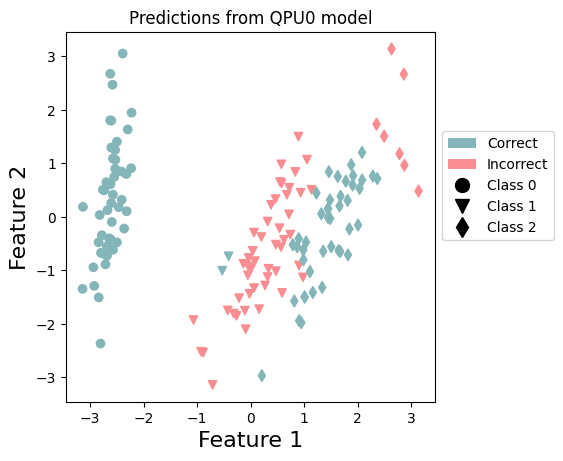

In [43]:
plot_points_prediction(x, y, np.append(p_train_0, p_test_0), "QPU0")  # QPU 0
plt.show()

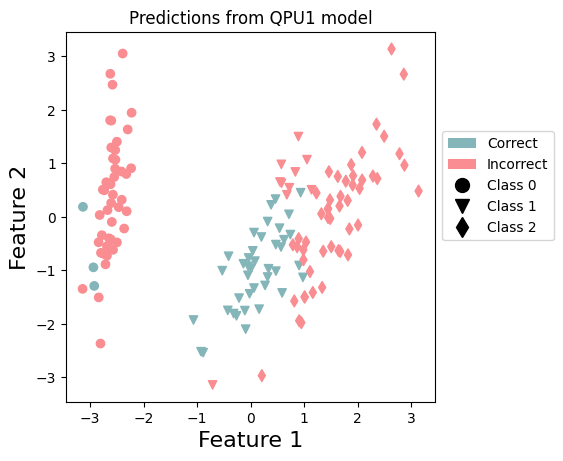

In [44]:
plot_points_prediction(x, y, np.append(p_train_1, p_test_1), "QPU1")  # QPU 1
plt.show()

In [40]:
qml.about()

Name: PennyLane
Version: 0.34.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/PennyLaneAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /home/martinet/PycharmProjects/Hybrid_QML/.venv/lib/python3.10/site-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, rustworkx, scipy, semantic-version, toml, typing-extensions
Required-by: PennyLane-Lightning, PennyLane-Lightning-GPU, PennyLane-Lightning-Kokkos, PennyLane-qiskit, PennyLane-Rigetti

Platform info:           Linux-6.5.0-15-generic-x86_64-with-glibc2.35
Python version:          3.10.12
Numpy version:           1.26.3
Scipy version:           1.12.0
Installed devices:
- default.gaussian (PennyLane-0.34.0)
- default.mixed (PennyLane-0.34.0)
- default.qubit (PennyLane-0.34.0)
- default.qubit.autograd (PennyLane-0.34.0)
- default.qubit.jax (PennyLane-0.34.0)
- default.qubit.legacy (PennyLane-0.34.